In [1034]:
import pacepredictor as pp
import importlib
import plotly.express as px
import pandas as pd
import numpy as np
import missingno as msno
import math

importlib.reload(pp)

<module 'pacepredictor' from '/home/adam/projects/Concept2-Pace-Predictor/pacepredictor.py'>

# Predictor

Create a regression model to predict 2000m time.

# Load Data

In [1035]:
file_path = "../Concept2-Logbook-Scraper/analysis/"
file_name = "rowing_cleaned_data.csv"

pp_row = pp.Predictor(f"{file_path}{file_name}", random_state=42)

pp_row.df = pp_row.df.drop("profile_id", axis = 1)

pp_row.df

,result_1,result_100,result_1000,result_10000,result_100000,result_2000,result_21097,result_30,result_4,result_42195,result_500,result_5000,result_60,result_6000,adaptive_rowing_category,age,height,weight,weight_class,gender
0,NaN,NaN,255.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,able,67,NaN,64.9,H,F
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.0,NaN,NaN,NaN,able,62,NaN,72.6,H,F
2,330.0,NaN,NaN,NaN,NaN,NaN,5688.1,NaN,NaN,NaN,NaN,NaN,NaN,1498.0,able,65,172.7,99.8,H,M
3,NaN,NaN,203.9,2222.6,NaN,416.4,NaN,8215.0,NaN,NaN,94.6,1086.8,16144.0,1307.6,able,56,188.0,97.1,H,M
4,NaN,NaN,236.3,2512.3,NaN,474.1,NaN,7289.0,1031.0,NaN,107.4,1204.7,NaN,1485.8,able,67,NaN,86.2,H,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1304.7,NaN,NaN,able,46,NaN,NaN,H,M
60689,NaN,NaN,230.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,able,17,NaN,NaN,H,F
60690,NaN,NaN,177.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,able,22,NaN,NaN,H,M
60691,NaN,NaN,NaN,3202.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,able,38,NaN,NaN,H,F


# Missing Data

In [1036]:
pp.percent_complete(pp_row.df)

result_1                     14.393752
result_100                   10.024220
result_1000                  25.121513
result_10000                 32.926367
result_100000                 0.301517
result_2000                  43.479479
result_21097                 13.706688
result_30                    35.368164
result_4                      7.556061
result_42195                  4.384361
result_500                   21.598866
result_5000                  46.021782
result_60                    11.767420
result_6000                  16.252286
adaptive_rowing_category    100.000000
age                         100.000000
height                       50.971282
weight                       56.077307
weight_class                100.000000
gender                      100.000000
dtype: float64


<AxesSubplot:>

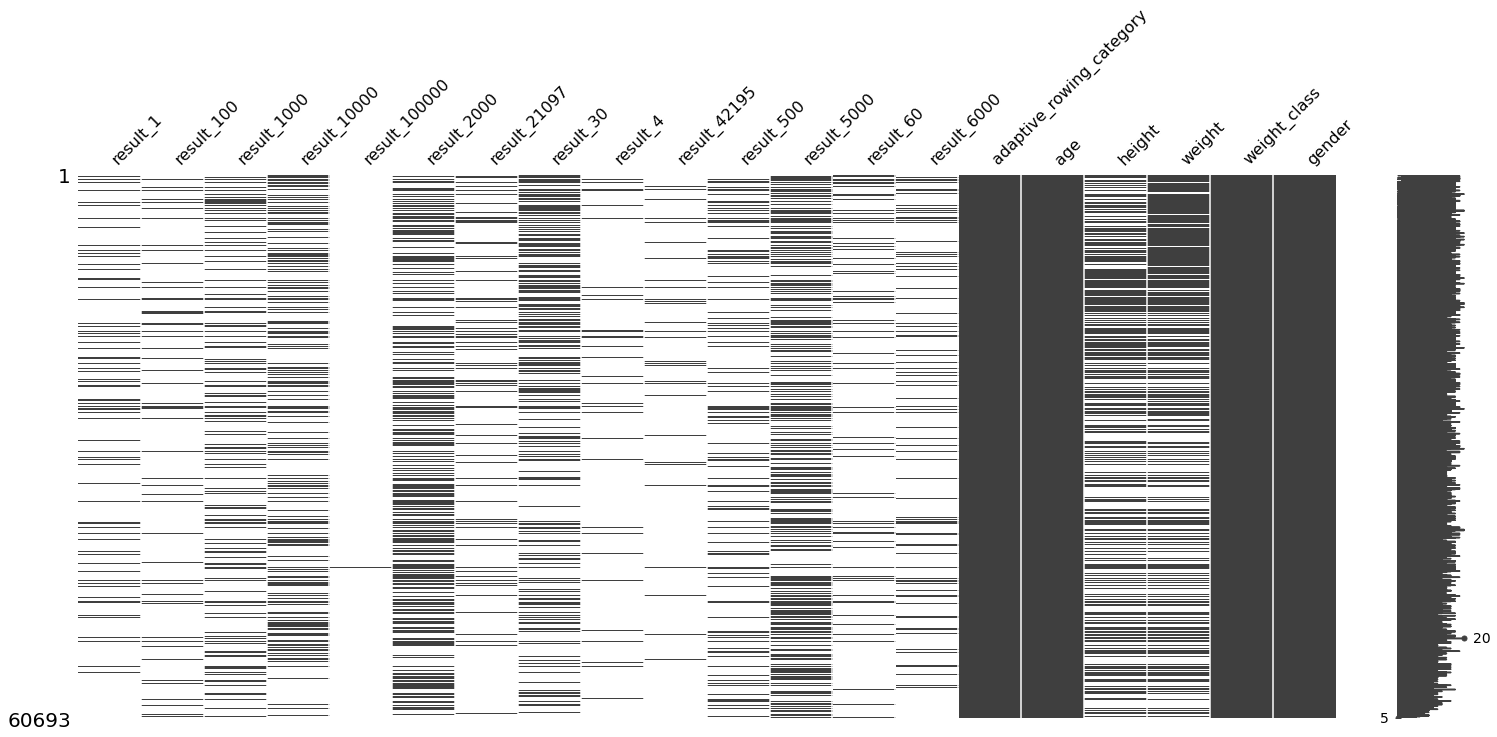

In [1037]:
msno.matrix(pp_row.df)

Lots of event results missing, and lots of height and weight missing. Is this data missing randomly or is there a correlation?

<AxesSubplot:>

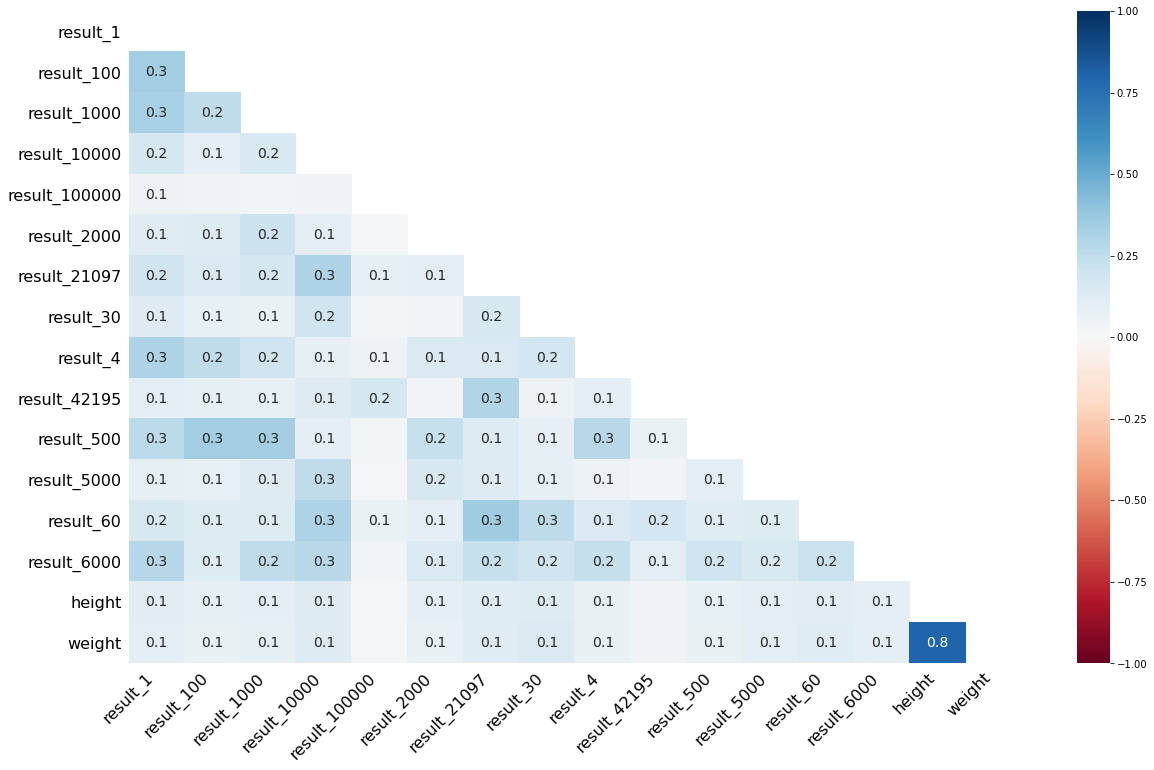

In [1038]:
msno.heatmap(pp_row.df)

The missing results are poorly correlated both with other results and with height and weight. Missing results means that the athlete has not recorded a result for this workout. This looks like we can treat this is MCAR (missing completely at random) data. We will drop missing results initially as I don't think imputing will yield good results and there will still be a good amount of data to work with.

Height and weight are highly correlated to eachother in their missingness, but this makes sense given that it is user input from the same web form. We only have about 50% height and weight data, which might be enough to get reasonable imputation, but we will also have plenty of data left if we drop the missing height and weight rows - we will take the later approach initially.

# Visualise Data Distribution

In [1039]:
# fig = pp_row.plot_distributions()
# fig.show()

# Further Cleaning

1. Cut off results at maximum at current men's 30-39 world record (usually the fastest time)

In [1040]:
distance_row_world_records = {
    100:12.6,
    500:70.5,
    1000:159.5,
    2000:336.6,
    5000:898.3,
    6000:1096.8,
    10000:1865.2,
    21097:4042.7,
    42195:8668.1
}

time_row_world_records = {
    1:430,
    4:1412,
    30:9449,
    60:18602
}


for event, record in distance_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > record else np.nan)

for event, record in time_row_world_records.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < record else np.nan)

2. Cut off anything slower than 3:00.0 / 500m pace

In [1041]:
distance_events_slow = {
    100:0,
    500:0,
    1000:0,
    2000:0,
    5000:0,
    6000:0,
    10000:0,
    21097:0,
    42195:0
}

time_events_slow = {
    1:0,
    4:0,
    30:0,
    60:0
}


#3:00.0 = 180 seconds
slow_cut_off_pace = 180

for event in distance_events_slow:
    distance_events_slow[event] = event/500 * slow_cut_off_pace

for event, slow_pace in distance_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x < slow_pace else np.nan)

for event in time_events_slow:
    time_events_slow[event] = (event*60)/slow_cut_off_pace * 500

for event, slow_pace in time_events_slow.items():
    pp_row.df[f"result_{event}"] = pp_row.df[f"result_{event}"].apply(lambda x: x if x > slow_pace else np.nan)

In [1042]:
fig = pp_row.plot_distributions()
#fig.show()

3. Include only able-bodied athletes in this model as we do not have enough para-athletes


In [1043]:
indexes_to_drop = pp_row.df[pp_row.df["adaptive_rowing_category"] != "able"].index
pp_row.df.drop(indexes_to_drop, inplace=True)
pp_row.df.drop("adaptive_rowing_category", axis=1, inplace=True)

4. Drop height and weight outliers - most likely errors on form entry

In [1044]:
max_height = 209
min_height = 150
max_weight = 150
min_weight = 45

indexes_to_drop = []
indexes_to_drop += pp_row.df[pp_row.df["height"] > max_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["height"] < min_height].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] > max_weight].index.to_list()
indexes_to_drop += pp_row.df[pp_row.df["weight"] < min_weight].index.to_list()

pp_row.df.drop(indexes_to_drop, inplace=True)

In [1045]:
fig = pp_row.plot_distributions()
# fig.show()

 # Visualisation
 
 Visualise the target against other variables

In [1046]:
target = "result_2000"
cont_parameters = pp_row.df.columns.drop([target, "weight_class", "gender"]).to_list()
fig = pp_row.plot_scatters(target, cont_parameters, cols=4)
# fig.show()
# plotly.io.write_image(fig, 'scatters.pdf', format='pdf')

In [1047]:
target = "result_2000"
cat_parameters = ["weight_class", "gender"]
fig = pp_row.plot_violins(target, cat_parameters, cols=2, height=1000)
#fig.show()

# Pick Parameters

There are very few profiles that have a complete set of parameters,and for a useful predictor, we don't want an athlete to have to complete every other test. We will keep all the other parameters which are not event results..

Ideally we choose shorter tests that athletes can complete easily, but that we also have a good amount of data for.



In [1048]:
pp.percent_complete(pp_row.df)

result_1          14.236355
result_100         9.752963
result_1000       24.414956
result_10000      32.500417
result_100000      0.302120
result_2000       42.487064
result_21097      13.463529
result_30         34.670339
result_4           7.217493
result_42195       4.221332
result_500        21.106660
result_5000       45.182774
result_60         11.625772
result_6000       15.957269
age              100.000000
height            50.652646
weight            55.606743
weight_class     100.000000
gender           100.000000
dtype: float64


We will choose two tests:
- 1000m (result_1000)
- 1 minute (result_1)



In [1049]:
target = ["result_2000"]
predictor_results = ["result_1", "result_1000"]
core_columns = ["age", "height", "weight", "weight_class", "gender"]

columns = target + predictor_results + core_columns

pp_row.df = pp_row.df[columns]

#drop nulls
indexes_to_drop = []
for col in columns:
    indexes_to_drop_temp = pp_row.df[pp_row.df[col].isnull()].index.to_list()
    #if len(indexes_to_drop_temp) > 0:
    indexes_to_drop += indexes_to_drop_temp

pp_row.df = pp_row.df.drop(indexes_to_drop)

How big is our dataset now?

In [1050]:
len(pp_row.df)

2553

In [1051]:
target = "result_2000"
cont_parameters = predictor_results + ["age", "height", "weight"]
fig = pp_row.plot_scatters(target, cont_parameters, cols=3, height=1500)
#fig.show()

In [1052]:
fig = px.imshow(pp_row.df[cont_parameters + ["result_2000"]].corr(), title="Correlation heatmap of numerical values")
fig.update_layout(height=800)
fig.show()

All the result parameters are highly correlated, to be expected. We will see how this affects the model but we may need to drop one of the predictor result parameters.

Height and weight also strongly correlated with eachother and results.

# Split Data

Need a train, validation and test set.

70% training data. 15% test and 15% validate

In [1053]:
pp_row.split_data()

print("Train: " + str(len(pp_row.df_train)))
print("Val: " + str(len(pp_row.df_test)))
print("Test: " + str(len(pp_row.df_val)))

Train: 1787
Val: 383
Test: 383


# Plot Linear Regression

In [1054]:
pp_row.df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2553 entries, 10 to 60451
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   result_2000   2553 non-null   float64
 1   result_1      2553 non-null   float64
 2   result_1000   2553 non-null   float64
 3   age           2553 non-null   int64  
 4   height        2553 non-null   float64
 5   weight        2553 non-null   float64
 6   weight_class  2553 non-null   object 
 7   gender        2553 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 179.5+ KB


In [1055]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("linear", target, parameters)

print(pp_row.models["linear"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1680.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:52:15   Log-Likelihood:                -7996.0
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1779   BIC:                         1.605e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           265.0040     21.23

In [1056]:
print(f"Mean squared error: {round(pp_row.models['linear'].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['linear'].mse),1)}s")

Mean squared error: 489.8s
Mean error: 22.1s


In [1057]:
fig = pp_row.models["linear"].plot_residuals()
fig.show()

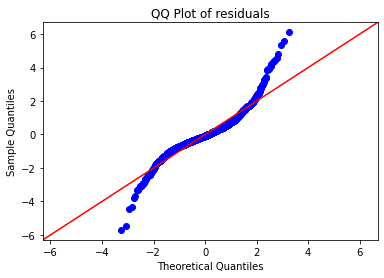

In [1058]:
pp_row.models["linear"].plot_QQ()

In [1059]:
pp_row.models["linear"].anova()

,sum_sq,df,F,PR(>F)
weight_class,63.914379,1.0,0.141123,7.072115e-01
gender,1953.774951,1.0,4.313950,3.794430e-02
result_1,29218.437018,1.0,64.514530,1.726592e-15
result_1000,817109.430520,1.0,1804.183797,8.603977e-273
age,11268.873820,1.0,24.881759,6.689992e-07
height,11387.948402,1.0,25.144676,5.848283e-07
weight,8934.109705,1.0,19.726582,9.484635e-06
Residual,805703.764262,1779.0,NaN,NaN


Weight class is contributing very little to the reduction in sum of squares, and has a high p. It will be highly correlated to weight (by definition) so we are probably best dropping this.

In [1060]:
pp_row.df.drop("weight_class", axis=1, inplace=True)


In [1061]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("linear_2", target, parameters)

print(pp_row.models["linear_2"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     1961.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:52:16   Log-Likelihood:                -7996.1
No. Observations:                1787   AIC:                         1.601e+04
Df Residuals:                    1780   BIC:                         1.604e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     266.7838     20.699     12.889      

In [1062]:
print(f"Mean squared error: {round(pp_row.models['linear_2'].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['linear_2'].mse),1)}s")
fig = pp_row.models["linear_2"].plot_residuals()
fig.show()

Mean squared error: 488.7s
Mean error: 22.1s


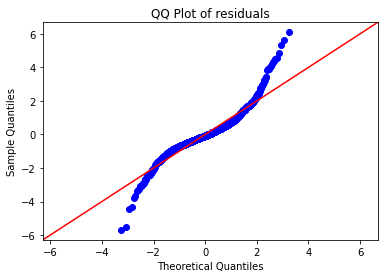

In [1063]:
pp_row.models["linear_2"].plot_QQ()

In [1064]:
pp_row.models["linear_2"].anova()

,sum_sq,df,F,PR(>F)
gender,1898.325421,1.0,4.193540,4.072474e-02
result_1,29215.574971,1.0,64.539352,1.705179e-15
result_1000,817081.751386,1.0,1804.993618,6.376365e-273
age,11213.964402,1.0,24.772471,7.074341e-07
height,12019.625269,1.0,26.552235,2.850033e-07
weight,10991.459563,1.0,24.280942,9.098380e-07
Residual,805767.678641,1780.0,NaN,NaN


Removing weight_class hasn't made a difference to our R^2 or model performance.

All p-values now under our alpha=0.05 threshold and this model is complete, though our residuals do not look normal and suggests a linear model is not a good fit for this data.

Interpretation:

- Being male decreases your 2km time.
- The higher your 1 minute score, the lower your 2km time.
- The lower your 1km time, the lower your 2km time.
- Being younger decreases your 2km time.
    - Rowers tend to peak in late 20s/early 30s, so would actually expect this to be a curve, given the limits of this model this result makes sense
- Being taller decreases your 2km time.
- Being lighter decreases your 2km time.
    - not expected, possibly because very trained lightweights are outperforming unfit heavyweight rowers



TODO: 
- notes on each plot
- try polynomial curve
- just 1 minute test
- compare with paul's law
- boxcox?

# Linear Regression with Polynomial Terms

## 2nd Order

In [1065]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("2nd_order", target, parameters, order=2)

print(pp_row.models["2nd_order"].model.summary())

                            OLS Regression Results                            
Dep. Variable:            result_2000   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     1080.
Date:                Mon, 05 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:52:16   Log-Likelihood:                -7986.5
No. Observations:                1787   AIC:                         1.600e+04
Df Residuals:                    1775   BIC:                         1.606e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       369.5877    160.981      2.296

Mean squared error: 6073.7s
Mean error: 77.9s


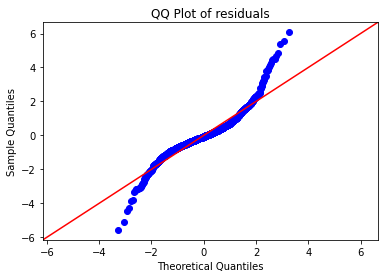

In [1066]:
print(f"Mean squared error: {round(pp_row.models['2nd_order'].mse,1)}s")
print(f"Mean error: {round(np.sqrt(pp_row.models['2nd_order'].mse),1)}s")
fig = pp_row.models["2nd_order"].plot_residuals()
fig.show()
pp_row.models["2nd_order"].plot_QQ()

In [1067]:
pp_row.models["2nd_order"].anova()

,sum_sq,df,F,PR(>F)
gender,1364.838577,1.0,3.038775,8.147040e-02
result_1,5761.130911,1.0,12.826997,3.508558e-04
result_1000,32927.541460,1.0,73.312251,2.359266e-17
age,1044.263274,1.0,2.325023,1.274865e-01
height,406.974178,1.0,0.906117,3.412765e-01
weight,431.340657,1.0,0.960368,3.272277e-01
result_1_2,3187.857709,1.0,7.097676,7.788254e-03
result_1000_2,5166.626281,1.0,11.503349,7.099536e-04
age_2,2800.994946,1.0,6.236337,1.260547e-02
height_2,231.269578,1.0,0.514915,4.731132e-01


Ever so slightly improved R^2.

Drop highest p:

In [1068]:
pp_row.models["2nd_order"].p_max()

Max p: weight_2 p=0.821


In [1069]:
target = "result_2000"
parameters = pp_row.df.columns.drop(target).to_list()
pp_row.add_model("2nd_order_2", target, parameters, order=2, drop="weight_2")

NameError: name 'drop' is not defined